# IoT Sensor Data Analysis

This notebook analyzes temperature and vibration sensor data from IoT devices to identify patterns and anomalies.

In [36]:
# Check versions for compatibility
import sys
import numpy as np
import pandas as pd
import matplotlib
import seaborn
print(f'Python version: {sys.version}')
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print(f'Seaborn version: {seaborn.__version__}')

# Standard imports
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

Python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
NumPy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.10.3
Seaborn version: 0.13.2


In [37]:
# Initialize BigQuery client with real credentials
client = bigquery.Client.from_service_account_json('../simulator/credentials.json')

In [38]:
# Fetch data from BigQuery (real setup)
query = """
SELECT 
    device_id,
    timestamp,
    temperature,
    vibration,
    is_anomaly
FROM `zeltask-staging-464722.iot_data.sensor_readings`
ORDER BY timestamp
"""

df = client.query(query).to_dataframe()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,device_id,timestamp,temperature,vibration,is_anomaly
0,sensor_0003,2025-08-06 13:47:54.665442+00:00,21.73,2.664,False
1,sensor_0043,2025-08-06 13:47:54.741614+00:00,19.64,3.194,False
2,sensor_0035,2025-08-06 13:47:55.420580+00:00,19.28,1.838,False
3,sensor_0025,2025-08-06 13:47:56.601012+00:00,19.67,2.858,False
4,sensor_0036,2025-08-06 13:47:56.891049+00:00,21.30,2.072,False


In [39]:
# Basic statistics (real BigQuery data)
df.describe()

,temperature,vibration
count,105834.000000,105834.000000
mean,19.880528,1.783603
std,2.473300,0.800520
min,9.900000,0.000000
25%,18.010000,1.116000
50%,19.970000,1.737000
75%,21.710000,2.469000
max,29.250000,4.419000


In [40]:
# Check for anomalies
anomalies = df[df['is_anomaly'] == True]
print(f"Total records: {len(df)}")
print(f"Anomalies: {len(anomalies)}")
print(f"Anomaly rate: {len(anomalies)/len(df)*100:.2f}%")

Total records: 105834
Anomalies: 0
Anomaly rate: 0.00%


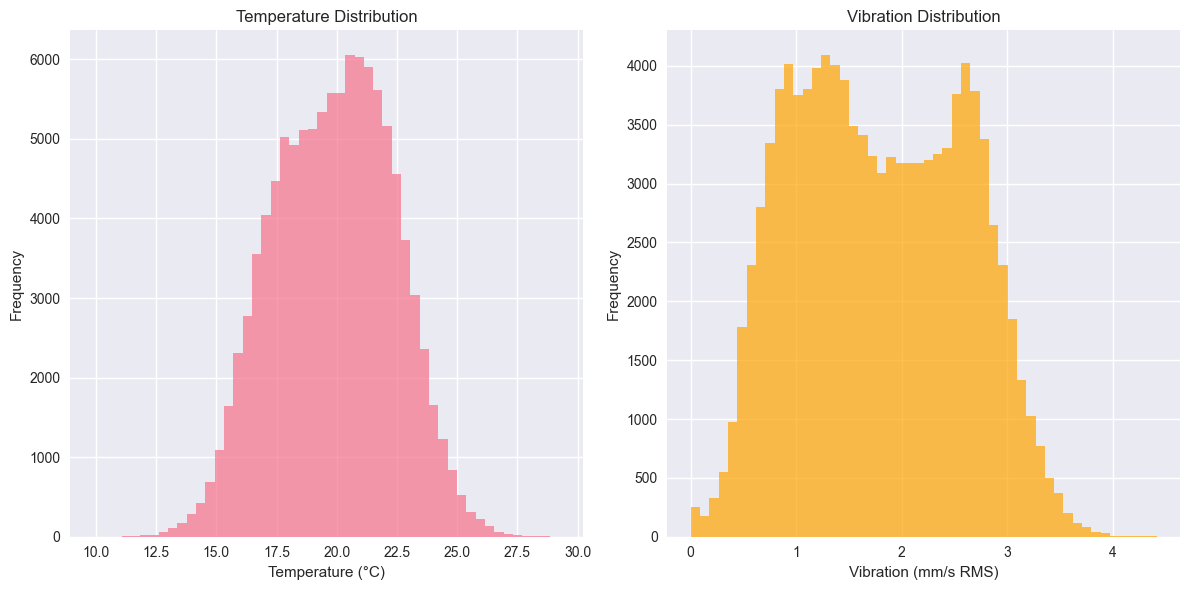

In [41]:
# Temperature distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['temperature'], bins=50, alpha=0.7)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['vibration'], bins=50, alpha=0.7, color='orange')
plt.title('Vibration Distribution')
plt.xlabel('Vibration (mm/s RMS)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

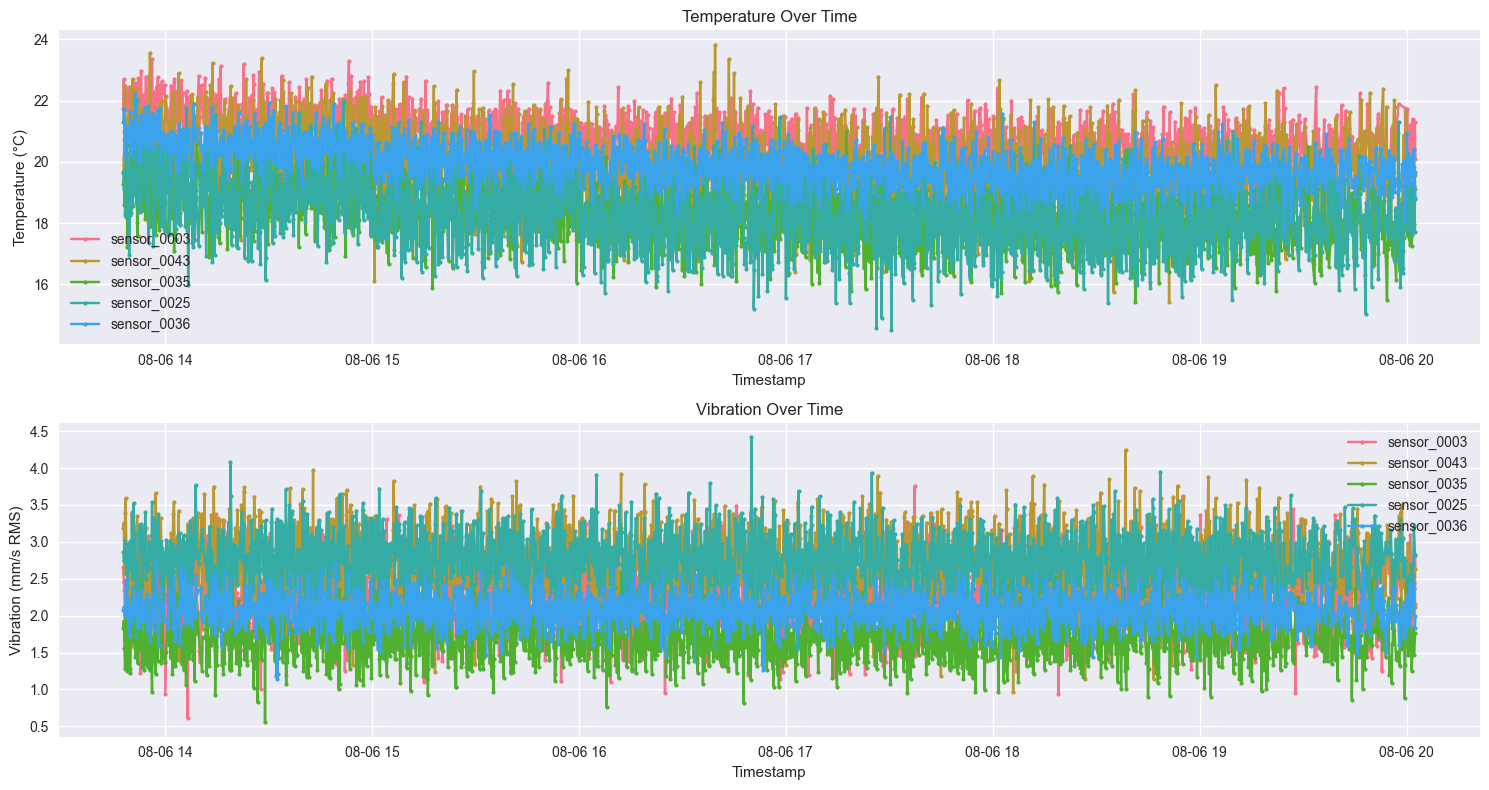

In [42]:
# Time series analysis
plt.figure(figsize=(15, 8))

# Sample a few devices for visualization
sample_devices = df['device_id'].unique()[:5]
sample_data = df[df['device_id'].isin(sample_devices)]

plt.subplot(2, 1, 1)
for device in sample_devices:
    device_data = sample_data[sample_data['device_id'] == device].sort_values('timestamp')
    if len(device_data) > 1:
        plt.plot(device_data['timestamp'], device_data['temperature'], label=device, marker='o', markersize=3)
    else:
        plt.scatter(device_data['timestamp'], device_data['temperature'], label=device, s=30)
plt.title('Temperature Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for device in sample_devices:
    device_data = sample_data[sample_data['device_id'] == device].sort_values('timestamp')
    if len(device_data) > 1:
        plt.plot(device_data['timestamp'], device_data['vibration'], label=device, marker='o', markersize=3)
    else:
        plt.scatter(device_data['timestamp'], device_data['vibration'], label=device, s=30)
plt.title('Vibration Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Vibration (mm/s RMS)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

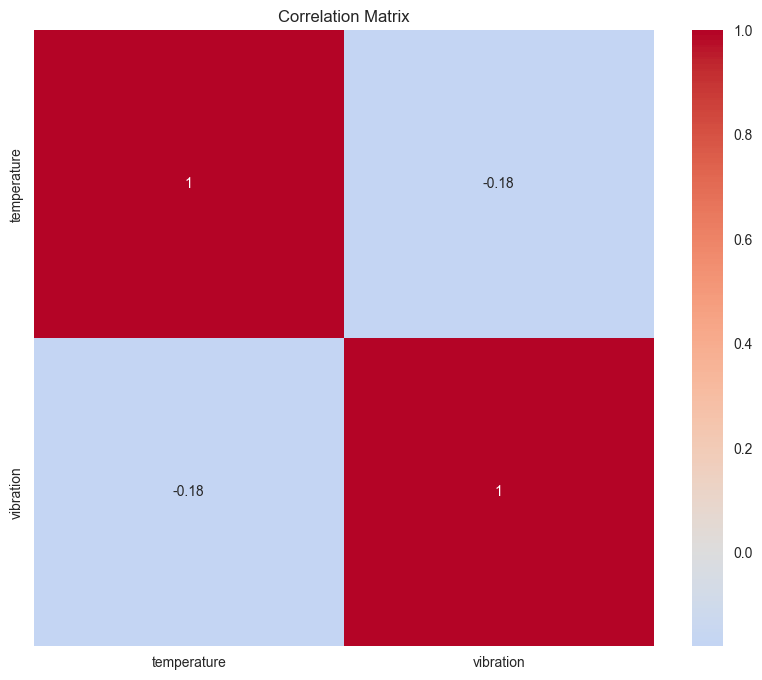

In [43]:
# Correlation analysis
plt.figure(figsize=(10, 8))
correlation_matrix = df[['temperature', 'vibration']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

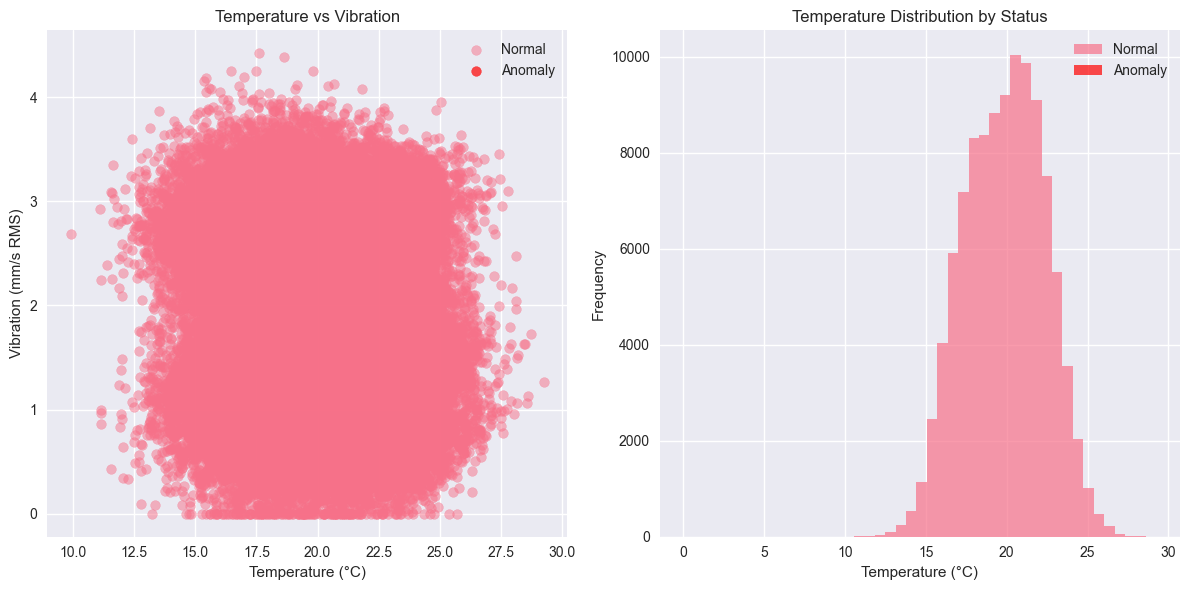

In [44]:
# Anomaly visualization
anomaly_data = df[df['is_anomaly'] == True]
normal_data = df[df['is_anomaly'] == False]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(normal_data['temperature'], normal_data['vibration'], alpha=0.5, label='Normal')
plt.scatter(anomaly_data['temperature'], anomaly_data['vibration'], alpha=0.7, color='red', label='Anomaly')
plt.xlabel('Temperature (°C)')
plt.ylabel('Vibration (mm/s RMS)')
plt.title('Temperature vs Vibration')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(normal_data['temperature'], bins=30, alpha=0.7, label='Normal')
plt.hist(anomaly_data['temperature'], bins=30, alpha=0.7, color='red', label='Anomaly')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Temperature Distribution by Status')
plt.legend()

plt.tight_layout()
plt.show()